In [9]:
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import TensorBoard
import os
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageEnhance
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, GlobalAveragePooling2D

In [10]:
# #tensorboard dir path
# log_dir = "logs/"  # Set the log directory path
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [11]:
x = [] #for spliced images
y = [] #1 for real and 0 for tampered

In [12]:
#ELA 
def ela_converter(path, scale = 70, quality = 85):
    org_img = Image.open(path).convert('RGB')
    resaved_img_name = 'resaved_img.jpg'
    org_img.save(resaved_img_name, 'JPEG', quality=quality)
    resaved_image = Image.open(resaved_img_name)
    
    #pixel diff
    ela_img = ImageChops.difference(org_img, resaved_image)
    extreme_pxl_vals = ela_img.getextrema()
    
    ela_img = ImageEnhance.Contrast(ela_img).enhance(scale)
    ela_img.save("ela_img.png")
    org_img.close()
    return ela_img

In [13]:
#preprocessing
def image_processor(full_image_path):
    image_size = (128,128)
    return np.array(ela_converter(full_image_path).resize(image_size)).flatten()/255.0
    

In [ ]:
#accessing directories
#TP
path_tp = r"E:\3rd_Year_CWIT\FYP\py_notebooks\Splicing\CASIA2\Tp"
for file_name in tqdm(os.listdir(path_tp), desc = "Preprocessing images: -"):
    if file_name.endswith('jpg') or file_name.endswith('png') or file_name.endswith('tif'):
        full_path = os.path.join(path_tp, file_name)
        x.append(image_processor(full_path))
        y.append(1)
print(f"Length of Images : - {len(x)}\n Length of labels: - {len(y)}")

In [ ]:
#AU
path_au = r"E:\3rd_Year_CWIT\FYP\py_notebooks\Splicing\CASIA2\Au"
for file_name in tqdm(os.listdir(path_au), desc = "Preprocessing images: -"):
    if file_name.endswith('jpg') or file_name.endswith('png') or file_name.endswith('tif'):
        full_path = os.path.join(path_au, file_name)
        x.append(image_processor(full_path))
        y.append(0)
print(f"Length of Images : - {len(x)}\n Length of labels: - {len(y)}")

In [ ]:
print(np.shape(x))
print(type(x))

In [ ]:
x = np.array(x)
y = np.array(y)
x = x.reshape(-1,128,128,3)

In [ ]:
#train, test, split

#dividing whole dataset | 70% train | 30% rem
x_train, x_rem, y_train, y_rem = train_test_split(x,y, train_size=0.7)
#spliting rem -> 50% test | 50% valid
x_test, x_valid, y_test, y_valid = train_test_split(x_rem,y_rem,test_size=0.5)

print(f"Total img: {len(x)} , Total labels: {len(y)}")

print(f"Validation img: {len(x_valid)} , Validation labels: {len(y_valid)}")

print(f"Training img: {len(x_train)} , Training labels: {len(y_train)}")

print(f"Test img: {len(x_test)} , Test labels: {len(y_test)}")

In [ ]:
# x_train = np.array(x_train)
# y_train = np.array(y_train)
# x_test = np.array(x_test)
# y_test = np.array(y_test)

In [ ]:
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(x_train))

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2

# Build model
def build_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='relu', input_shape=(128, 128, 3)))
    model.add(Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='relu'))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='relu'))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, kernel_size=(4, 4), strides=(1, 1), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(4, 4), strides=(1, 1), padding='same', activation='relu'))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

optm = Adam(learning_rate=0.001)
model = build_model()
model.compile(optimizer=optm, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
tensorboard_callback = TensorBoard(log_dir="logs/", histogram_freq=1)

In [ ]:
history = model.fit(x_train, y_train, batch_size=32, epochs=12, validation_data=(x_valid, y_valid), callbacks=[tensorboard_callback])

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

In [ ]:
### saving model
model.save("splicing_cnn_model.h5")

In [ ]:
correct_test = 0 #correctly predicted test images
total_test = 0   #total test images

for index,image in enumerate(tqdm(x_test,desc="Processing Images : ")):
    image = image.reshape(-1, 128, 128, 3)
    y_pred = model.predict(image)
    y_pred_class = np.round(y_pred)
    total_test += 1
    if y_pred_class == y_test[index]: #if prediction is correct
        correct_test += 1
    
print(f'Total test images: {total_test}\nCorrectly predicted images: {correct_test}\nAccuracy: {correct_test / total_test * 100.0} %')

1/1 [==============================] - 0s 252ms/step
[[0.9947919]]
Prediction: Forged
Confidence: 99.48%
--------------------------------------------------------------------------------------------------------------


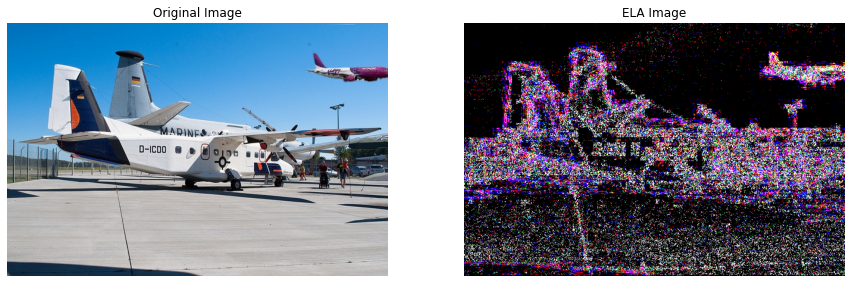

In [15]:
class_names = [ 'Authentic' , 'Forged']
test_image_path = r"E:\3rd_Year_CWIT\FYP\py_notebooks\Splicing\test\test9.tif" # test image path
test_image = process_image(test_image_path)
test_image = test_image.reshape(-1, 128, 128, 3)
model_m = load_model("splicing_cnn_model.h5")
y_pred = model_m.predict(test_image)
y_pred_class = round(y_pred[0][0])

fig, ax = plt.subplots(1,2,figsize=(15,5)) 

#display original image
original_image = plt.imread(test_image_path) 
ax[0].axis('off')
ax[0].imshow(original_image)
ax[0].set_title('Original Image')

#display ELA applied image
ax[1].axis('off')
ax[1].imshow(convert_to_ela(test_image_path,90)) 
ax[1].set_title('ELA Image')

print(y_pred)
print(f'Prediction: {class_names[y_pred_class]}')
if y_pred<=0.5:
    print(f'Confidence:  {(1-(y_pred[0][0])) * 100:0.2f}%')
else:
    print(f'Confidence: {(y_pred[0][0]) * 100:0.2f}%')
print('--------------------------------------------------------------------------------------------------------------')